In [18]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from scipy.optimize import minimize
from scipy.integrate import quad
from iminuit import Minuit
import pandas as pd

In [19]:
df = pd.read_csv("fsigma8_data.dat", sep=";")
print(df)

z = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_max = np.array((df['fsig8_err_plus'].copy()).tolist())

a_list = np.array([])
for element in z:
    a_list = np.append(a_list,(1/(1+element)))
print(a_list)

print("max z = ",np.max(z),"min z =",np.min(z))

        Survey      z  fsig8  fsig8_err_plus  fsig8_err_minus
0         2MFT  0.000  0.505           0.089            0.079
1        6dFGS  0.067  0.423           0.055            0.055
2    SDSS DR13  0.100  0.480           0.160            0.160
3       2dFGRS  0.170  0.510           0.060            0.060
4         GAMA  0.200  0.430           0.050            0.050
5      WiggleZ  0.220  0.420           0.070            0.070
6   BOSS LOW Z  0.250  0.471           0.024            0.024
7         GAMA  0.380  0.440           0.060            0.060
8   BOSS LOW Z  0.400  0.431           0.025            0.025
9      WiggleZ  0.410  0.450           0.040            0.040
10  CMASS BOSS  0.570  0.453           0.022            0.022
11     WiggleZ  0.600  0.430           0.040            0.040
12      VIPERS  0.600  0.480           0.120            0.120
13     SDSS IV  0.690  0.447           0.039            0.039
14     SDSS IV  0.770  0.432           0.038            0.038
15     W

Text(42.597222222222214, 0.5, 'fσ₈')

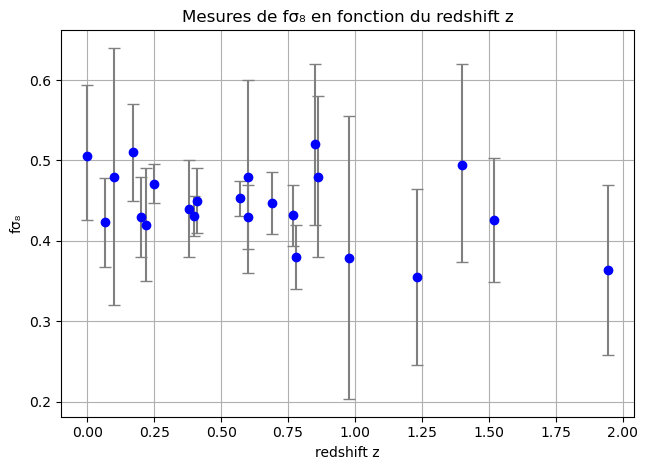

In [20]:
plt.errorbar(z,fsig8,yerr=[fsig8_err_minus,fsig8_err_max],fmt='o',ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.title("Mesures de fσ₈ en fonction du redshift z")
plt.grid(True)
plt.xlabel("redshift z")
plt.tight_layout()
plt.ylabel("fσ₈")

In [21]:

def fsimga8(omega_m,S8,f):
    return f*S8*np.sqrt(0.3/omega_m)
    

def Chi2(omega_m,S8,f):
    chi2 = 0
    for i in range(len(fsig8)):
        chi2 += (fsig8[i]-fsimga8(omega_m,S8,f)/fsig8_err_minus[i])**2
    return chi2


minimizer = Minuit(Chi2,omega_m = 0.3,S8 = 0.5,f = 10)
minimizer.limits["omega_m"] = (0,1)
minimizer.limits["S8"] = (0,1)
minimizer.limits["f"] = (0,1)
minimizer.migrad()

print(minimizer)




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.235                      │              Nfcn = 91               │
│ EDM = 2.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

In [22]:
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Définir les paramètres

H0 = 70  # Valeur typique pour H0 en km/s/Mpc
a_start =  0.01
a_end =  1# Définir H(a)
step = 1e-4
nb_sample = int(np.abs(a_end - a_start)/step) + 1
Omega_m0 = 0.3

def H(a):
    return H0 * np.sqrt(Omega_m0 /a**3 + (1 - Omega_m0))

# Définir Omega_m(a)
def Omega_m(a,Omega_m0):
    return Omega_m0*(H0**2) /((a**3)*(H(a)**2))

# Calculer d(ln H(a)^2)/d(ln a)
def dlnH2_dlna(a,Omega_m0):
    return -3 * Omega_m0 / (Omega_m0 + (1 - Omega_m0) * a**3)

# Définir l'équation différentielle
def dfdlna(ln_a, f):
    a = np.exp(ln_a)
    return -f**2 - (2 + 0.5 * dlnH2_dlna(a,Omega_m0)) * f + 1.5 * Omega_m(a,Omega_m0)

# Conditions initiales
f0 = [1]  # Valeur initiale pour f(a)

# Intervalle de ln(a)
ln_a_span = (np.log(a_start), np.log(a_end))

# Résoudre l'EDO


# Tracer la solution

fsol = solve_ivp(dfdlna, ln_a_span, f0, t_eval=np.linspace(np.log(a_start), np.log(a_end),nb_sample))
plt.plot(np.exp(fsol.t), fsol.y[0])


plt.xscale('log')
plt.xlabel('a')
plt.ylabel('f(a)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid(True)
plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")
plt.show()


z_ = np.array([])

for i in range(len(fsol.t)):
    z_ = np.append(z_,(1-np.exp(fsol.t[i]))/np.exp(fsol.t[i]))
    

plt.plot(z_, fsol.y[0],color = 'r')
plt.gca().invert_xaxis()
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid()
plt.show()
"""





<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\2762374131.py:1: SyntaxWarning: invalid escape sequence '\O'
  """


'\n\nimport numpy as np\nfrom scipy.integrate import solve_ivp\nimport matplotlib.pyplot as plt\n\n# Définir les paramètres\n\nH0 = 70  # Valeur typique pour H0 en km/s/Mpc\na_start =  0.01\na_end =  1# Définir H(a)\nstep = 1e-4\nnb_sample = int(np.abs(a_end - a_start)/step) + 1\nOmega_m0 = 0.3\n\ndef H(a):\n    return H0 * np.sqrt(Omega_m0 /a**3 + (1 - Omega_m0))\n\n# Définir Omega_m(a)\ndef Omega_m(a,Omega_m0):\n    return Omega_m0*(H0**2) /((a**3)*(H(a)**2))\n\n# Calculer d(ln H(a)^2)/d(ln a)\ndef dlnH2_dlna(a,Omega_m0):\n    return -3 * Omega_m0 / (Omega_m0 + (1 - Omega_m0) * a**3)\n\n# Définir l\'équation différentielle\ndef dfdlna(ln_a, f):\n    a = np.exp(ln_a)\n    return -f**2 - (2 + 0.5 * dlnH2_dlna(a,Omega_m0)) * f + 1.5 * Omega_m(a,Omega_m0)\n\n# Conditions initiales\nf0 = [1]  # Valeur initiale pour f(a)\n\n# Intervalle de ln(a)\nln_a_span = (np.log(a_start), np.log(a_end))\n\n# Résoudre l\'EDO\n\n\n# Tracer la solution\n\nfsol = solve_ivp(dfdlna, ln_a_span, f0, t_eval=np.

<>:48: SyntaxWarning: invalid escape sequence '\O'
<>:48: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\3114466162.py:48: SyntaxWarning: invalid escape sequence '\O'
  plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\3114466162.py:29: RuntimeWarning: overflow encountered in exp
  a = np.exp(ln_a)


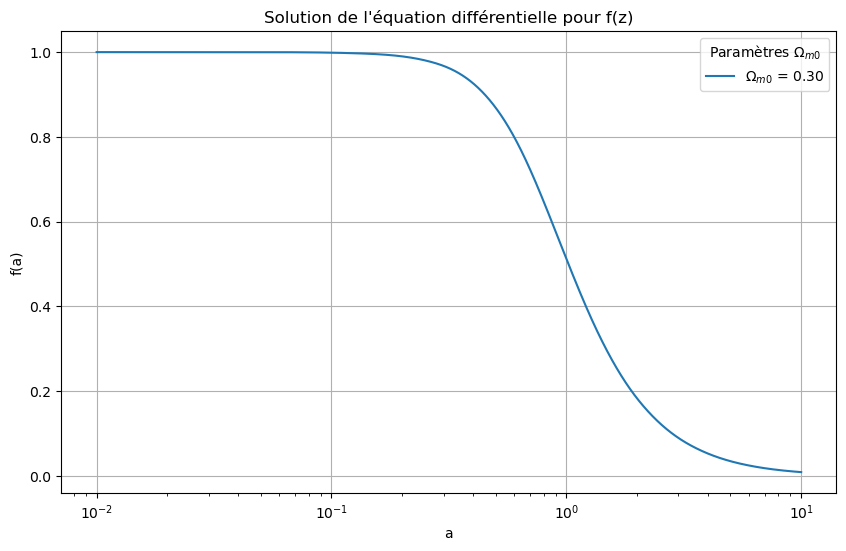

"\nfor i in range(len(fsol.t)):\n    z_ = np.append(z_,(1-np.exp(fsol.t[i]))/np.exp(fsol.t[i]))\n    \n\nplt.plot(z_, fsol.y[0],color = 'r')\nplt.gca().invert_xaxis()\nplt.xlabel('z')\nplt.ylabel('f(z)')\nplt.title('Solution de l'équation différentielle pour f(z)')\nplt.grid()\nplt.show()\n\n\n"

In [23]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constantes générales
H0 = 70  # Hubble constant
a_start = 0.01
a_end = 10.0
step = 1e-4
nb_sample = int(np.abs(a_end - a_start) / step) + 1
ln_a_vals = np.linspace(np.log(a_start), np.log(a_end), nb_sample)

f0 = [1.0]  # condition initiale

# Liste des Omega_m0 à tester
omega_M0_list = np.linspace(0.3, 0.3,1)

# Fonctions dépendant de Omega_m0 — on passera ce paramètre séparément
def H(a, Omega_m0):
    return H0 * np.sqrt(Omega_m0 / a**3 + (1 - Omega_m0))

def Omega_m(a, Omega_m0):
    return Omega_m0  / (Omega_m0+(1-Omega_m0)*a**3)

def dlnH2_dlna(a, Omega_m0):
    return -3 * Omega_m0 / (Omega_m0 + (1 - Omega_m0) * a**3)

def dfdlna(ln_a, f, Omega_m0):
    a = np.exp(ln_a)
    return -f**2 - (2 + 0.5 * dlnH2_dlna(a, Omega_m0)) * f + 1.5 * Omega_m(a, Omega_m0)

# Tracer pour chaque Omega_m0
plt.figure(figsize=(10, 6))
a = np.array([])
for Omega_m0 in omega_M0_list:
    # Utilisation de lambda pour injecter le paramètre dans l'équation différentielle
    sol = solve_ivp(lambda ln_a, f: dfdlna(ln_a, f, Omega_m0),(ln_a_vals[0], ln_a_vals[-1]),f0,t_eval=ln_a_vals)
    a = np.exp(sol.t)
    plt.plot(np.exp(sol.t), sol.y[0], label=f"$\\Omega_{{m0}}$ = {Omega_m0:.2f}")

# Mise en forme

plt.xlabel('a')
plt.xscale('log')
plt.ylabel('f(a)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid(True)
plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")
plt.show()

"""
for i in range(len(fsol.t)):
    z_ = np.append(z_,(1-np.exp(fsol.t[i]))/np.exp(fsol.t[i]))
    

plt.plot(z_, fsol.y[0],color = 'r')
plt.gca().invert_xaxis()
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid()
plt.show()


"""

In [24]:
"""import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Définir les paramètres
Omega_m0 = 0.315  # Valeur typique pour Omega_m,0
H0 = 70  # Valeur typique pour H0 en km/s/Mpc
z_start =  2  # Redshift initial
z_end =  0   #Redshift final
step =1e-4
nb_sample_= int(np.abs(z_end - z_start)/step) + 1

# Définir H en fonction de z
def H(z):
    a = 1 / (1 + z)
    return H0 * np.sqrt(Omega_m0* a**(-3) + (1 - Omega_m0))

# Définir Omega_m en fonction de z
def Omega_m(z):
    a = 1 / (1 + z)
    return Omega_m0 * (H0**2) / (a**3 * H(z)**2)

# Calculer d(ln H^2)/d(ln a) en fonction de z
def dH2_dz(z):
    a = 1 / (1 + z)
    return 3*(H0**2)*Omega_m0*(1+z)**2

# Définir l'équation différentielle en fonction de z
def dfdz(z, f):
    a = 1 / (1 + z)
    return (1/(1+z)) * ( f**2 + (2 + 0.5 *(1+z) * (H(z)**(-2)) * dH2_dz(z)) * f - 1.5 * Omega_m(z) )

# Conditions initiales
f0 = [1]  # Valeur initiale pour f(z)

# Intervalle de z
z_span = (z_start,z_end)

# Résoudre l'EDO
solz = solve_ivp(dfdz, z_span, f0, t_eval=np.linspace(z_start,z_end,nb_sample_))

print(nb_sample)
# Tracer la solution

plt.plot(solz.t,solz.y[0])
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid()
plt.show()

print(np.min(solz.y[0]))
#t_eval=np.linspace(z_start,z_end,2001)"""



"import numpy as np\nfrom scipy.integrate import solve_ivp\nimport matplotlib.pyplot as plt\n\n# Définir les paramètres\nOmega_m0 = 0.315  # Valeur typique pour Omega_m,0\nH0 = 70  # Valeur typique pour H0 en km/s/Mpc\nz_start =  2  # Redshift initial\nz_end =  0   #Redshift final\nstep =1e-4\nnb_sample_= int(np.abs(z_end - z_start)/step) + 1\n\n# Définir H en fonction de z\ndef H(z):\n    a = 1 / (1 + z)\n    return H0 * np.sqrt(Omega_m0* a**(-3) + (1 - Omega_m0))\n\n# Définir Omega_m en fonction de z\ndef Omega_m(z):\n    a = 1 / (1 + z)\n    return Omega_m0 * (H0**2) / (a**3 * H(z)**2)\n\n# Calculer d(ln H^2)/d(ln a) en fonction de z\ndef dH2_dz(z):\n    a = 1 / (1 + z)\n    return 3*(H0**2)*Omega_m0*(1+z)**2\n\n# Définir l'équation différentielle en fonction de z\ndef dfdz(z, f):\n    a = 1 / (1 + z)\n    return (1/(1+z)) * ( f**2 + (2 + 0.5 *(1+z) * (H(z)**(-2)) * dH2_dz(z)) * f - 1.5 * Omega_m(z) )\n\n# Conditions initiales\nf0 = [1]  # Valeur initiale pour f(z)\n\n# Intervalle d

In [25]:
def tri_f_simu(z_):
    f_sim = np.array([])
    z_ = np.round(z_,3)
    c = 0
    
    for element in z:
        for i in range(1,len(z_)):
            if element == z_[i] and z_[i-1] != z_[i]:
                f_sim = np.append(f_sim,sol.y[0][i-1])
                c+=1
    f_sim =  np.abs(f_sim)
    print(c)
    return f_sim
    
    


In [26]:




def omega_mGamma(a,gamma,omega_m0):
    res = np.array([])
    for i in range(len(a)):
        res = np.append(res,(omega_m0*(1/(omega_m0+(1-omega_m0)*a[i]**3)))**gamma)
    return res

def div_appVsSolved(app,sol):
    res = np.array([])
    for i in range(len(app)):
        if (app[i] or sol[i]) != 0:
            res = np.append(res,app[i]/sol[i])
            
    return res


In [27]:
def calculate_alpha(w, Omega):
    # Calcul de la première partie de l'équation
    term1 = 3 / (5 - w / (1 - w))

    # Calcul de la deuxième partie de l'équation
    term2 = (3 / 125) * ((1 - w) * (1 - 3 * w / 2) * (1 - Omega)) / ((1 - 6 * w / 5) ** 3)

    # Calcul de la troisième partie de l'équation

    # Calcul de alpha
    alpha = term1 + term2 

    return alpha

# Exemple d'utilisation
w = -1  # exemple de valeur pour w
Omega = 0.3  # exemple de valeur pour Omega
gamma = calculate_alpha(w, Omega)



<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\123802827.py:3: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(a, omega_mGamma(a, gamma, omega_m0), label=f"$\Omega_{{m0}}$ = {omega_m0:.2f}")
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\123802827.py:10: SyntaxWarning: invalid escape sequence '\O'
  plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")


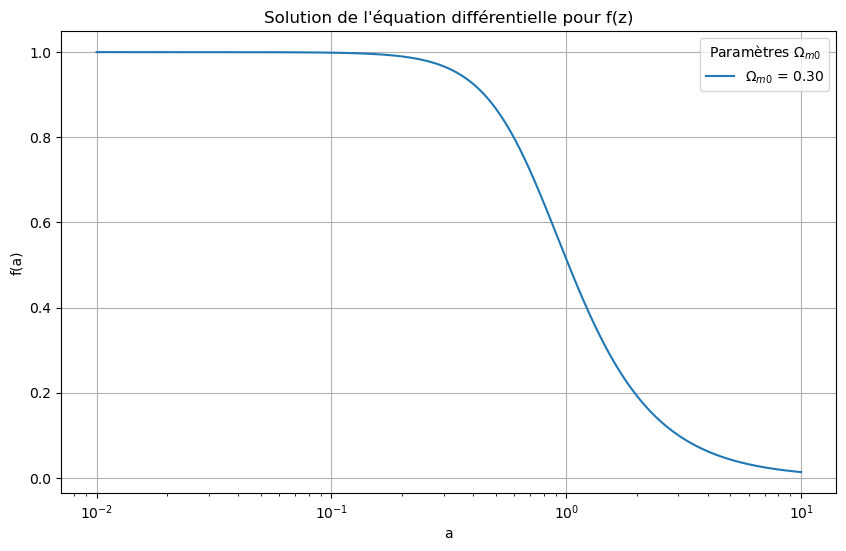

In [28]:

plt.figure(figsize=(10, 6))
for omega_m0 in omega_M0_list:
    plt.plot(a, omega_mGamma(a, gamma, omega_m0), label=f"$\Omega_{{m0}}$ = {omega_m0:.2f}")

plt.xscale('log')
plt.xlabel('a')
plt.ylabel('f(a)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid(True)
plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")
plt.show()

In [29]:
def div_appVsSolved(app,sol):
    res = np.array([])
    for i in range(len(app)):
        if (app[i] or sol[i]) != 0:
            res = np.append(res,app[i]/sol[i])
            
    return res

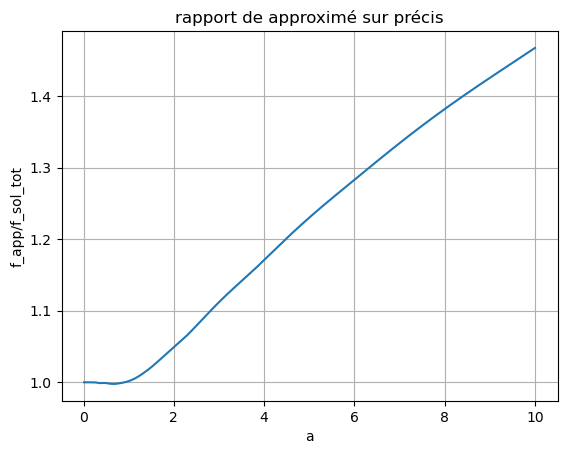

In [30]:
y = div_appVsSolved(omega_mGamma(np.exp(sol.t),gamma,0.3),sol.y[0])
plt.plot(np.exp(sol.t),y)
plt.xlabel('a')
plt.ylabel('f_app/f_sol_tot')
plt.title('rapport de approximé sur précis')
plt.grid()
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_20812\1900982624.py:9: SyntaxWarning: invalid escape sequence '\O'
  plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")


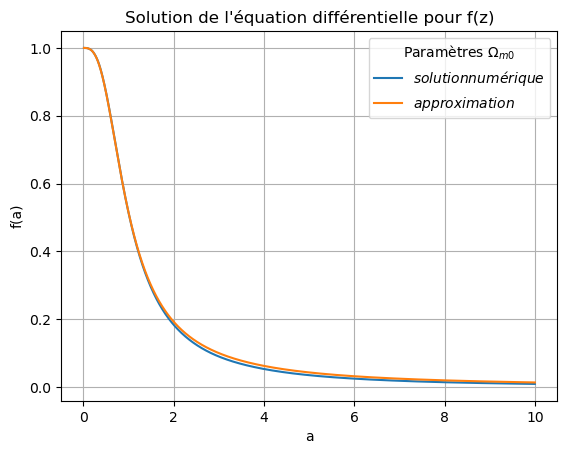

In [31]:
plt.plot(np.exp(sol.t),sol.y[0],label=f"$solution numérique$")
plt.plot(a, omega_mGamma(a, gamma,0.3), label=f"$approximation$")

#plt.xscale('log')
plt.xlabel('a')
plt.ylabel('f(a)')
plt.title('Solution de l\'équation différentielle pour f(z)')
plt.grid(True)
plt.legend(title="Paramètres $\Omega_{m0}$", loc="best")
plt.show()

In [32]:

"""from scipy.optimize import minimize
from scipy.integrate import quad
from iminuit import Minuit

def fsimga8(omega_m,S8,f):
    return f*S8*np.sqrt(0.3/omega_m)
    

def Chi2(omega_m,S8):
    chi2 = 0
    
    for i in range(len(fsig8)):
        chi2 += (fsig8[i]-fsimga8(omega_m,S8,f[i])/fsig8_err_minus[i])**2
    return chi2


minimizer = Minuit(Chi2,omega_m = 0.3,S8 = 0.9)
minimizer.limits["omega_m"] = (0,1)
minimizer.limits["S8"] = (0,1)

minimizer.migrad()

print(minimizer)
"""

'from scipy.optimize import minimize\nfrom scipy.integrate import quad\nfrom iminuit import Minuit\n\ndef fsimga8(omega_m,S8,f):\n    return f*S8*np.sqrt(0.3/omega_m)\n    \n\ndef Chi2(omega_m,S8):\n    chi2 = 0\n    \n    for i in range(len(fsig8)):\n        chi2 += (fsig8[i]-fsimga8(omega_m,S8,f[i])/fsig8_err_minus[i])**2\n    return chi2\n\n\nminimizer = Minuit(Chi2,omega_m = 0.3,S8 = 0.9)\nminimizer.limits["omega_m"] = (0,1)\nminimizer.limits["S8"] = (0,1)\n\nminimizer.migrad()\n\nprint(minimizer)\n'